# Baseline 
Baseline solution for VarDial 2022 shared task on Italian Dialect Classification. 

In [2]:
# load the dataset
import pandas as pd
data = pd.read_csv("data/train.csv", ) 

In [3]:
data

text  label
0             Al funsiòuna da 'l 11 ed novèmber dal 2016.      0
1       Al 2017  'l è 'n an dal XXI sécol dal Calendàr...      0
2       Siligo i è un comun d'la Sardàggna d' 890 abit...      0
3       Valparaisol’é na cmûna e la capitèl d'l sud d'...      0
4       Queschè 'l è 'n elèinc di povéta ch'i àn scrìt...      0
...                                                   ...    ...
388776   A pustis, colat dae sas poesias a sas cummèdias.     10
388777  Sa prima cummèdia sua est  Sa rebelliòni de is...     10
388778           In su 2010 l'ant torrada a rapresentare.     10
388779  Sa de duas cummèdia est  Sa littra de mariedda...     10
388780  Sa sua de tres e ùrtima cummèdia est  Sa Parte...     10

[388781 rows x 2 columns]

In [4]:
X = data['text'].values
y = data['label'].values.astype(int)
print(X.shape, y.shape)

(388781,) (388781,)


Vectorize and scale the training data.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer()
scaler = StandardScaler(with_mean=False)
X = vectorizer.fit_transform(X)
X = scaler.fit_transform(X)

In [6]:
X.shape

(388781, 480442)

Cross-validation k-fold cross validation initialization.

In [ ]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

Train a Logistic Regression classifier with the extracted features.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

model = LogisticRegression(random_state=0, n_jobs=-1, solver="sag")
scores = cross_val_score(model, X, y, scoring='f1_micro', cv=rkf, n_jobs=-1)
print(f'Repeated cross-validation scores: {np.mean(scores)} ({np.std(scores)})')

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# from utils import explain_label

# vocab = vectorizer.get_feature_names_out()

# for label in data['label'].unique():
#     slicer = y_train == label
#     f = X_train[slicer]
#     total_freqs = list(np.array(f.sum(axis=0))[0])
#     fdict = dict(zip(vocab,total_freqs))
#     # generate word cloud of words with highest counts
#     wordcloud = WordCloud().generate_from_frequencies(fdict) 
#     print(explain_label(label=label))
#     plt.clf()
#     plt.imshow(wordcloud, interpolation='bilinear') 
#     plt.axis("off") 
#     plt.show()

## Evaluation 

Import devset.

In [7]:
from utils import encode_label

data = pd.read_csv("data/dev.txt", sep = "\t", names=["label", "sample"])
data['label'] = data['label'].apply(encode_label)
data.head(10)

label                                             sample
0      6  Ma te see foeura de coo, ò te me toeuvet in gir?.
1      8                              a carni re puvireddi.
2      6  L'era on simpatich tradizional appontament con...
3      9  Chi un tenpo xè stà zovane adesso se consola b...
4      5  ma òua scià no coménse a fâse do mâ da sôlo, a...
5      8  ti lassai sula, comu na varca senza vela, a te...
6      8                     Nun savi 'a sacrificari nenti.
7      8            Na notti chi û senti passari sutta i so
8      9  Da seno a mi me par Che no ghe sia rason de ba...
9      3  Lis ruedis di fat a corevin dentri de cjarador...

Retrain the model on the whole training set.

In [8]:
from sklearn.linear_model import LogisticRegression

import numpy as np

model = LogisticRegression(random_state=0, n_jobs=-1, solver="sag")
model.fit(X, y)

/opt/homebrew/Caskroom/miniforge/base/envs/cs4nlp/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, random_state=0, solver='sag')

Vectorize devset.

In [9]:
X_dev, y_true = data['sample'], data['label']
X_dev = vectorizer.transform(X_dev)
X_dev = scaler.transform(X_dev)

Evaluate predictions with confusion matrix.

In [10]:
y_pred = model.predict(X_dev)

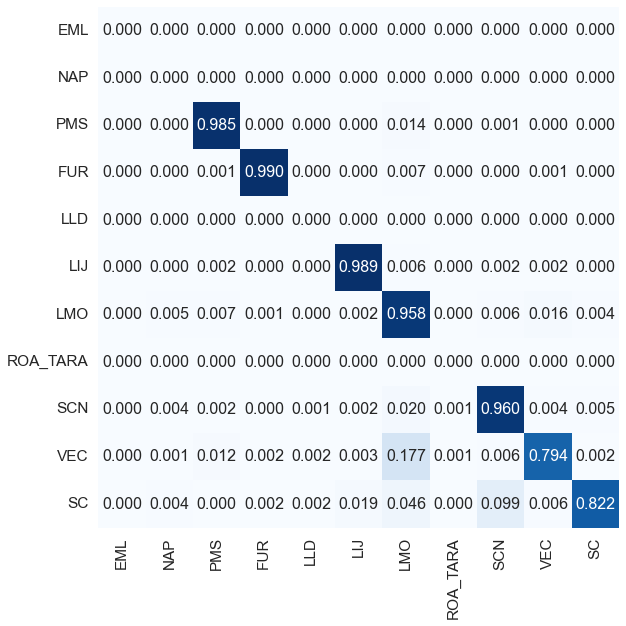

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize="true", labels=range(0,11))

from utils import explain_label
df_cm = pd.DataFrame(cm, index = [explain_label(i) for i in range(0,11)],
                  columns = [explain_label(i) for i in range(0,11)])

plt.figure(figsize = (9, 9))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16}, 
            fmt='.3f', 
            cmap="Blues",
            cbar=False) 
plt.tight_layout()  

# plt.savefig('confusion.pdf')
plt.show()

In [12]:
from sklearn.metrics import f1_score

f1 = f1_score(y_true, y_pred, average=None)
for score, label in zip(f1, ['EML', 'NAP', 'PMS', 'FUR', 'LLD', 'LIJ', 'LMO', 'ROA_TARA', 'SCN', 'VEC','SC']):
    print(f"{label}: {score}")

EML: 0.0
NAP: 0.980359381529461
PMS: 0.9911111111111112
FUR: 0.0
LLD: 0.9791332263242375
LIJ: 0.8717190388170055
LMO: 0.0
ROA_TARA: 0.9567430025445294
SCN: 0.8727758007117438
VEC: 0.8878822197055494


In [13]:
from utils import explain_label

df = pd.DataFrame(y_pred, columns=["label"])
df['label'] = df['label'].apply(explain_label)
df.to_csv("data/pred.csv", header=None, index=None)

In [14]:
wrong = []
for i, x in enumerate(data['sample']):
    if y_true[i] != y_pred[i]:
        wrong.append(i)